In [119]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.INFO)
import sys

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
0.76470596


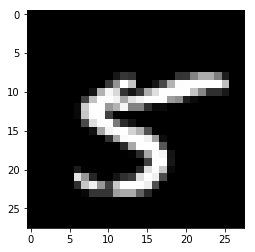

In [120]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [16]:
eval_data = SP.Scaling(eval_data,.8)

In [18]:
eval_data = Exposure(eval_data,+60)

In [6]:
eval_data = SP.Rotation(eval_data,30)

In [69]:
eval_data = Translation(eval_data,2)

In [121]:
train_labels = np.copy(train_data)
randm = np.random.choice(55000,40000,replace=False)
i=0
while i in range(0,randm.shape[0]-8):
    train_data[randm[i]] = SP.Exposure(train_data[randm[i]],60)
    train_data[randm[i+1]] = SP.Rotation(train_data[randm[i+1]],30)
    train_data[randm[i+2]] = SP.Translation(train_data[randm[i+2]],2)
    train_data[randm[i+3]] = SP.Scaling(train_data[randm[i+3]],0.6)
    train_data[randm[i+4]] = SP.Exposure(train_data[randm[i+4]],-60)
    train_data[randm[i+5]] = SP.Rotation(train_data[randm[i+5]],-30)
    train_data[randm[i+6]] = SP.Scaling(train_data[randm[i+6]],1.5)
    train_data[randm[i+7]] = SP.Translation(train_data[randm[i+7]],2)
    i+=8

In [4]:
train_data = SP.Exposure(train_data,60)

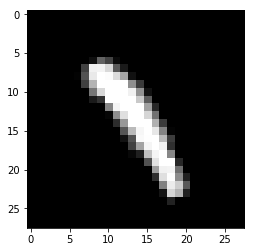

In [122]:
SP.Display(train_data,33337)

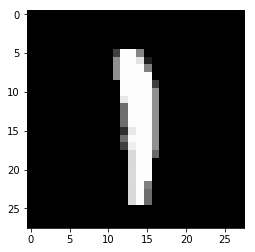

In [123]:
SP.Display(train_labels,33337)

In [124]:
train_labels = train_labels.reshape(-1,28,28,1)

In [125]:
def l0_loss(labels,predictions):
    print(labels.shape,predictions.shape)
    sess = tf.InteractiveSession()
    #shape is 256x28x28x1 for each
    a = tf.losses.mean_squared_error(labels=labels,predictions=predictions)
    a.eval()
    print(type(a))
#     print(type(labels),type(predictions))
    #type is tensor
    
    #last dimension deleted
    labels = tf.reshape(labels,[-1,28,28])
    predictions = tf.reshape(predictions,[-1,28,28])
    
    #counting number of different pixels
    count = 0
    
    #flattening layers for faster computation
    labels = tf.contrib.layers.flatten(labels)
    predictions = tf.contrib.layers.flatten(predictions)
    #shape is 256x784
#     print(labels.shape,predictions.shape)
    labels = tf.contrib.layers.flatten(labels)
    predictions = tf.contrib.layers.flatten(predictions)
    
#     print(labels.shape,predictions.shape)
    for i in range(0,labels.shape[0]):
        count+=tf.count_nonzero(abs(labels[i]-predictions[i]))
    print("end")
    return count

In [126]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=4,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.contrib.layers.max_pool2d(inputs=conv1, kernel_size=2)
    
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=8,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool2 = tf.contrib.layers.max_pool2d(inputs=conv2,  kernel_size=2)
    
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=16,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool3 = tf.contrib.layers.max_pool2d(inputs=conv3,  kernel_size=2)
    
#     print(pool3.shape)
    
    conv4 = tf.layers.conv2d_transpose(
        inputs=pool3,
        filters=16,
        strides = 2,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    conv5 = tf.layers.conv2d_transpose(
        inputs=conv4,
        filters=8,
        strides = 2,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    conv6 = tf.layers.conv2d_transpose(
        inputs=conv5,
        filters=4,
        strides = 2,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
#     print(conv6.shape)

    conv7 = tf.layers.conv2d_transpose(
        inputs=conv6,
        filters=1,
        kernel_size=[3, 3],
        padding="same",
        activation=None)
    
#     print(conv7.shape)
    
    paddings = tf.constant([[0, 0,], [2, 2],[2,2],[0,0]])

    conv7 = tf.pad(conv7, paddings, "CONSTANT") 
    
#     print(conv7.shape)
#     print(labels.shape)
    predictions = {
        "logits": conv7
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.mean_squared_error(labels=labels, predictions=conv7)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
                tf.cast(labels, tf.float64), tf.cast(conv7, tf.float64))
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [127]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_denoisingautoencoderall2")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
# tensors_to_log = {"probabilities": "softmax_tensor"}
# logging_hook = tf.train.LoggingTensorHook(
#   tensors=tensors_to_log, every_n_iter=50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './models/mnist_denoisingautoencoderall2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4e161d5828>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [128]:
def current_loss(flag,data=train_data,labels=train_labels):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": data[flag].reshape(28,28)},
      y=labels[flag],
      shuffle=False)
    eval_result1=mnist_classifier.predict(input_fn=train_eval_input_fn)
    a = list(eval_result1)[0]['logits']
    plt.subplot(231)
    plt.imshow(data[flag].reshape(28,28),cmap='gray')
    plt.subplot(232)
    plt.imshow(a.reshape(28,28),cmap='gray')
    plt.subplot(233)
    plt.imshow(labels[flag].reshape(28,28),cmap='gray')
    plt.show()

started

Training
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall2/model.ckpt-4
INFO:tensorflow:Saving checkpoints for 5 into ./models/mnist_denoisingautoencoderall2/model.ckpt.
INFO:tensorflow:loss = 0.1040606, step = 5
INFO:tensorflow:global_step/sec: 48.9405
INFO:tensorflow:loss = 0.08358218, step = 105 (2.044 sec)
INFO:tensorflow:global_step/sec: 51.9851
INFO:tensorflow:loss = 0.08931285, step = 205 (1.923 sec)
INFO:tensorflow:global_step/sec: 52.5019
INFO:tensorflow:loss = 0.092094585, step = 305 (1.905 sec)
INFO:tensorflow:global_step/sec: 52.3796
INFO:tensorflow:loss = 0.08859904, step = 405 (1.910 sec)
INFO:tensorflow:global_step/sec: 51.5757
INFO:tensorflow:loss = 0.09446157, step = 505 (1.938 sec)
INFO:tensorflow:global_step/sec: 52.2623
INFO:tensorflow:loss = 0.086502604, step = 605 (1.914 sec)
INFO:tensorflow:global_step/sec: 52.542
INFO:tensorflow:loss = 0.0922776, step = 705 (1.904 sec)
INFO:tens

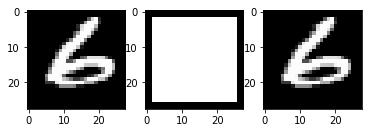

Step
Training
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall2/model.ckpt-1004
INFO:tensorflow:Saving checkpoints for 1005 into ./models/mnist_denoisingautoencoderall2/model.ckpt.
INFO:tensorflow:loss = 0.091812715, step = 1005
INFO:tensorflow:global_step/sec: 47.8903
INFO:tensorflow:loss = 0.088952065, step = 1105 (2.090 sec)
INFO:tensorflow:global_step/sec: 51.5143
INFO:tensorflow:loss = 0.09155143, step = 1205 (1.941 sec)


KeyboardInterrupt: 

In [129]:
print("started\n")
# Train the model
while 1:
    
# Train the model
    print("Training")
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=256,
      num_epochs=None,
      shuffle=True)

    mnist_classifier.train(
      input_fn=train_input_fn,
      steps=1000,
      hooks=None,)
    c = np.random.randint(0,55000)
    current_loss(c)
    print("Step")
#     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.98:
#        break
#     print(curr_result)
    
print ("Finished")

In [ ]:
eval_labels = np.copy(eval_data)

In [13]:
eval_data = SP.Scaling(eval_data,1.2)

In [48]:
eval_labels = eval_labels.reshape(-1,28,28)
eval_data = eval_data.reshape(-1,28,28)

In [50]:
current_loss(c,eval_data,eval_labels)

IndexError: index 12652 is out of bounds for axis 0 with size 10000